In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt

In [2]:
import os

def rename_images_in_folder(folder, prefix):
    """
    Renames all images in a specified folder with a given prefix.

    Args:
        folder (str): Path to the folder containing the images.
        prefix (str): Prefix for the new image names.
    """
    # Get a list of files in the folder
    files = os.listdir(folder)

    # Filter only files with common image extensions
    valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}
    images = [file for file in files if os.path.splitext(file)[1].lower() in valid_extensions]

    # Step 1: Add a temporary prefix to avoid conflicts
    temp_prefix = "temp_"
    for index, image in enumerate(images):
        extension = os.path.splitext(image)[1]
        current_path = os.path.join(folder, image)
        temp_name = f"{temp_prefix}{index}{extension}"
        temp_path = os.path.join(folder, temp_name)
        os.rename(current_path, temp_path)

    # Step 2: Rename files with the desired prefix
    temp_files = os.listdir(folder)  # Reload the updated file list
    temp_images = [file for file in temp_files if file.startswith(temp_prefix)]
    for index, temp_image in enumerate(temp_images, start=1):
        extension = os.path.splitext(temp_image)[1]
        temp_path = os.path.join(folder, temp_image)
        new_name = f"{prefix}{index}{extension}"
        new_path = os.path.join(folder, new_name)
        os.rename(temp_path, new_path)

    print(f"{len(images)} images have been renamed in the folder {folder}.")

# Usage examples
#rename_images_in_folder("./data/strawberry/healthy", "strawberry_healthy_")
#rename_images_in_folder("./data/strawberry/Leaf_scorch", "strawberry_leaf_scorch_")





456 images have been renamed in the folder ./data/strawberry/healthy.


In [9]:
import os
import shutil
import pathlib

# Directory paths
original_dir = pathlib.Path("./data/strawberry/alldata")
new_base_dir = pathlib.Path("./data/strawberry/strawberry_healthy_diseased_alldata_small")

# Function to create subsets
def make_subset(category, subset_name, start_index, end_index):
    """
    Creates a subset of images for a specific category.

    Args:
        category (str): Category ('strawberry_healthy' or 'strawberry_leaf_scorch').
        subset_name (str): Subset ('train', 'validation', 'test').
        start_index (int): Starting index of the images to copy.
        end_index (int): Ending index of the images to copy.
    """
    # Create the destination directory
    dir = new_base_dir / subset_name / category
    os.makedirs(dir, exist_ok=True)

    # Generate file names and copy files
    fnames = [f"{category}_{i}.JPG" for i in range(start_index, end_index + 1)]
    for fname in fnames:
        src = original_dir / fname
        dst = dir / fname
        if src.exists():  # Check if the file exists before copying
            shutil.copyfile(src, dst)

# Create subsets for each category
# Healthy
make_subset("strawberry_healthy", "train", start_index=1, end_index=182)
make_subset("strawberry_healthy", "validation", start_index=183, end_index=274)
make_subset("strawberry_healthy", "test", start_index=274, end_index=456)

# Diseased
make_subset("strawberry_leaf_scorch", "train", start_index=1, end_index=442)
make_subset("strawberry_leaf_scorch", "validation", start_index=443, end_index=663)
make_subset("strawberry_leaf_scorch", "test", start_index=664, end_index=1109)



In [51]:
from tensorflow.keras.utils import image_dataset_from_directory

data_folder = pathlib.Path('./data/strawberry/strawberry_healthy_diseased_alldata_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(224, 224), 
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(224, 224),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(224, 224),
    batch_size=32)


Found 624 files belonging to 2 classes.
Found 313 files belonging to 2 classes.
Found 629 files belonging to 2 classes.


In [28]:
from tensorflow.keras import layers, models
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)



In [29]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch_1207.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)              

Epoch 1/10


20/20 [==============================] - 53s 2s/step - loss: 16.3451 - accuracy: 0.6426 - val_loss: 1.0446 - val_accuracy: 0.7061
Epoch 2/10
20/20 [==============================] - 39s 2s/step - loss: 0.7723 - accuracy: 0.6827 - val_loss: 0.4836 - val_accuracy: 0.7061
Epoch 3/10
20/20 [==============================] - 39s 2s/step - loss: 0.8843 - accuracy: 0.6362 - val_loss: 0.6780 - val_accuracy: 0.7061
Epoch 4/10
20/20 [==============================] - 42s 2s/step - loss: 1.0344 - accuracy: 0.6587 - val_loss: 0.5682 - val_accuracy: 0.7061
Epoch 5/10
20/20 [==============================] - 39s 2s/step - loss: 0.9762 - accuracy: 0.6571 - val_loss: 0.5797 - val_accuracy: 0.6997
Epoch 6/10
20/20 [==============================] - 43s 2s/step - loss: 0.6988 - accuracy: 0.7292 - val_loss: 0.9276 - val_accuracy: 0.6262
Epoch 7/10
20/20 [==============================] - 42s 2s/step - loss: 1.3306 - accuracy: 0.7997 - val_loss: 0.4647 - val_accuracy: 0.7604
Epoch 8/10
20/20 [============

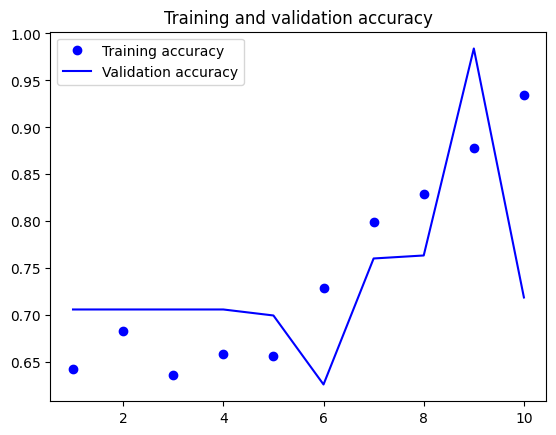

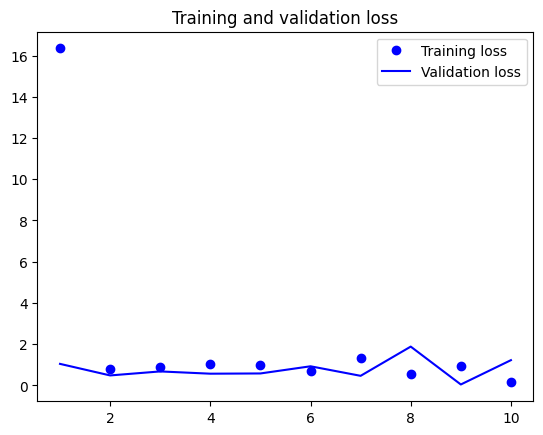

In [30]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [31]:
test_model = keras.models.load_model("./models/convnet_from_scratch_1207.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

20/20 [==============================] - 11s 507ms/step - loss: 0.0753 - accuracy: 0.9650
Test accuracy: 0.965


20/20 [==============================] - 8s 381ms/step
Confusion Matrix:
[[ 56 127]
 [149 297]]


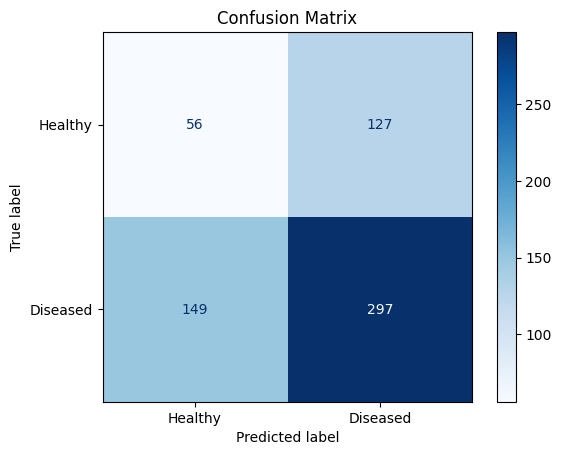


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.27      0.31      0.29       183
    Diseased       0.70      0.67      0.68       446

    accuracy                           0.56       629
   macro avg       0.49      0.49      0.49       629
weighted avg       0.58      0.56      0.57       629



In [33]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load model
test_model = tf.keras.models.load_model("./models/convnet_from_scratch_1207.keras")

# Get predictions
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_prob = test_model.predict(test_dataset)
y_pred = (y_pred_prob > 0.5).astype(int)  # Binary threshold at 0.5

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                            display_labels=['Healthy', 'Diseased'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print metrics
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, 
                         target_names=['Healthy', 'Diseased']))

vgg model

In [52]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))


In [53]:
import numpy as np
#features extraction
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)



2024-12-08 18:22:36.034161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [624]
	 [[{{node Placeholder/_4}}]]
2024-12-08 18:22:36.041202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [624]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 3s 3s/step


2024-12-08 18:24:25.893977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [313]
	 [[{{node Placeholder/_4}}]]
2024-12-08 18:24:25.894483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [313]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 4s 4s/step


2024-12-08 18:25:19.087427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [629]
	 [[{{node Placeholder/_4}}]]
2024-12-08 18:25:19.088067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [629]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 3s 3s/step


In [57]:
#top layer with augmentation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_toplayer = keras.Model(inputs, outputs)

In [59]:
#save model
model_toplayer.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction_with_augmentation_1207.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model_toplayer.fit(
    train_features, train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)


Epoch 1/10


ValueError: in user code:

    File "/Users/jianting/Desktop/Conestoga/CSCN8010/venv/tensorflow_cpu/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/jianting/Desktop/Conestoga/CSCN8010/venv/tensorflow_cpu/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/jianting/Desktop/Conestoga/CSCN8010/venv/tensorflow_cpu/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/jianting/Desktop/Conestoga/CSCN8010/venv/tensorflow_cpu/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/jianting/Desktop/Conestoga/CSCN8010/venv/tensorflow_cpu/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/jianting/Desktop/Conestoga/CSCN8010/venv/tensorflow_cpu/lib/python3.11/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_5" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 7, 7, 512)


In [ ]:
#plot
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
#evaluate model
test_model_toplayer = keras.models.load_model(
    "./models/feature_extraction_1207.keras")
test_loss, test_acc = test_model_toplayer.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")
